In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, confusion_matrix, roc_curve, roc_auc_score, auc,mean_squared_error
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
smoke_df = pd.read_csv('smoke_detection_iot.csv')
smoke_df.drop(smoke_df.columns[0],axis=1,inplace = True)


In [17]:
smoke_df.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [67]:
smoke_df.shape

(62630, 15)

In [38]:
mask=smoke_df.isnull().values
smoke_df[mask]

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm


In [41]:
dup_mask=smoke_df.duplicated().values
smoke_df[dup_mask]

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm


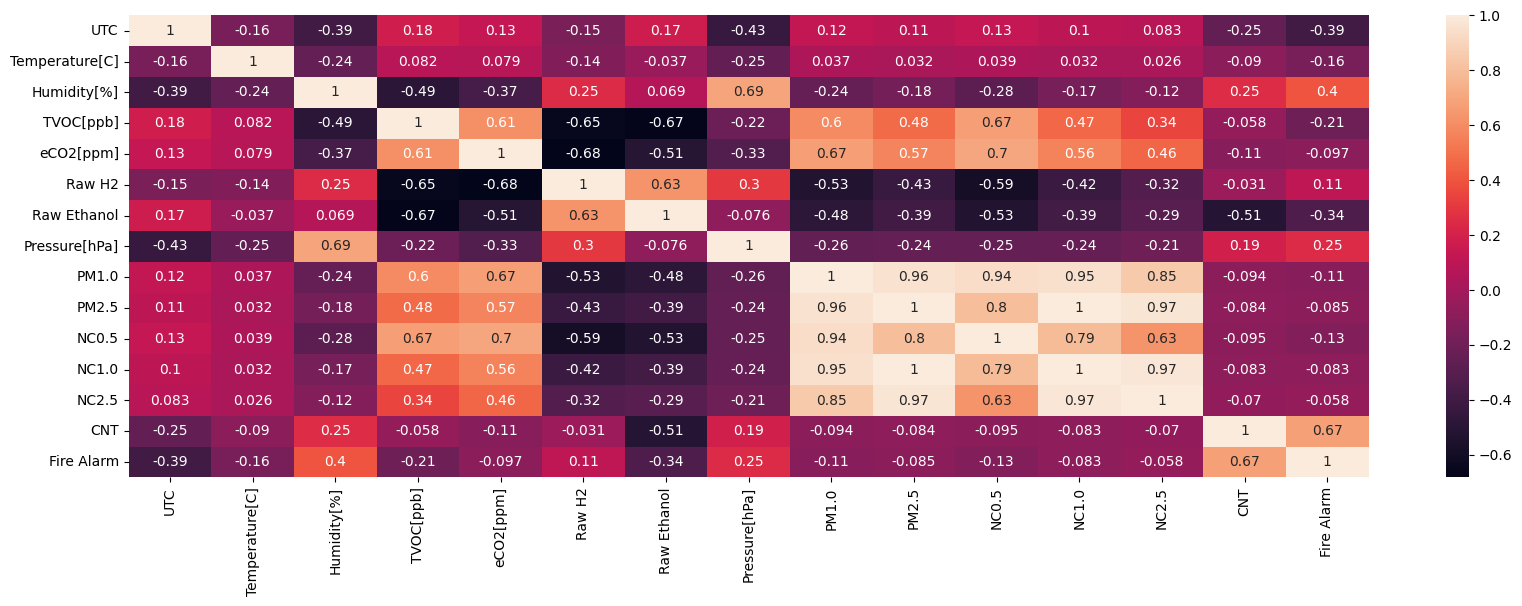

In [16]:
plt.figure(figsize=(20,6))
sns.heatmap(smoke_df.corr(),annot=True)
plt.show()

Seems like we have really high correlations for Particulate Matter Size (PM1.0 & PM2.5) and Number Concentration of particulate matter(NC0.5,NC1.0,NC2.5).
We'll take a middle ground and drop PM1.0, NC0.5, and NC1.0

C:\Users\Angus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


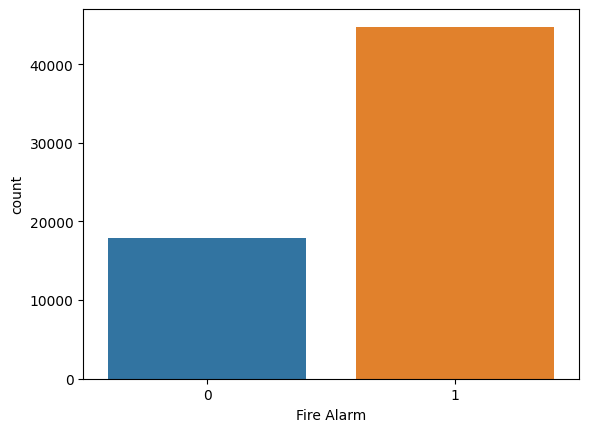

In [25]:
g = sns.countplot(smoke_df['Fire Alarm'])
plt.show()

We see a slight imbalance in results. We'll keep this in mind and keep oversampling and undersampling as an option in mind.

In [51]:
X = smoke_df.iloc[:,0:-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
X_scaled = pd.DataFrame(X,columns=['UTC','Temperature[C]','Humidity[%]','TVOC[ppb]','eCO2[ppm]','Raw H2','Raw Ethanol','Pressure[hPa]','PM1.0','PM2.5','NC0.5','NC1.0','NC2.5','CNT'])
X_scaled = X_scaled.drop(['UTC','PM1.0','NC0.5','NC1.0'],axis=1)
X_scaled.rename(columns={'Temperature[C]':'Temperature(C)','Humidity[%]':'Humidity(%)','TVOC[ppb]':'TVOC(ppb)','eCO2[ppm]':'eCO2(ppm)','Pressure[hPa]':'Pressure(hPa)'},inplace=True)
y = smoke_df['Fire Alarm']
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=41)

In [52]:
X_scaled.head()

,Temperature(C),Humidity(%),TVOC(ppb),eCO2(ppm),Raw H2,Raw Ethanol,Pressure(hPa),PM2.5,NC2.5,CNT
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,1
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,2
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,3
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,4


In [53]:
logit = LogisticRegression()
logit.fit(X_train,y_train)
proba_logit = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_logit)
print("The score for logistic regression is")
print("Training: {:.2f}%".format(100*logit.score(X_train, y_train)))
print("Training Precision Score: {:.2f}".format(precision_score(y_train,logit.predict(X_train))))
print("Training F1 Score: {:.2f}".format(f1_score(y_train,logit.predict(X_train))))

print("Test set: {:.2f}%".format(100*logit.score(X_test, y_test)))
print("Test Precision Score: {:.2f}".format(precision_score(y_test,logit.predict(X_test))))
print("Test F1 Score: {:.2f}".format(f1_score(y_test,logit.predict(X_test))))

The score for logistic regression is
Training: 98.87%
Training Precision Score: 1.00
Training F1 Score: 0.99
Test set: 99.02%
Test Precision Score: 1.00
Test F1 Score: 0.99


C:\Users\Angus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


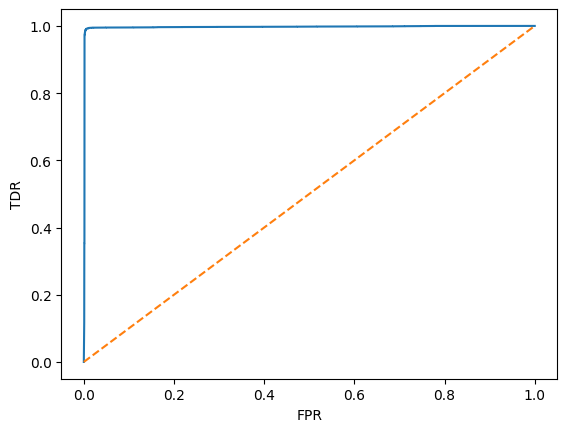

In [54]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TDR')
plt.show()

In [62]:
logit_solver = LogisticRegression(solver='liblinear')
logit_solver.fit(X_train,y_train)
proba_logit = logit_solver.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_logit)
print("The score for logistic regression is")
print("Training: {:.2f}%".format(100*logit_solver.score(X_train, y_train)))
print("Training Precision Score: {:.2f}".format(precision_score(y_train,logit_solver.predict(X_train))))
print("Training F1 Score: {:.2f}".format(f1_score(y_train,logit_solver.predict(X_train))))

print("Test set: {:.2f}%".format(100*logit_solver.score(X_test, y_test)))
print("Test Precision Score: {:.2f}".format(precision_score(y_test,logit_solver.predict(X_test))))
print("Test F1 Score: {:.2f}".format(f1_score(y_test,logit_solver.predict(X_test))))

The score for logistic regression is
Training: 98.87%
Training Precision Score: 1.00
Training F1 Score: 0.99
Test set: 99.00%
Test Precision Score: 1.00
Test F1 Score: 0.99


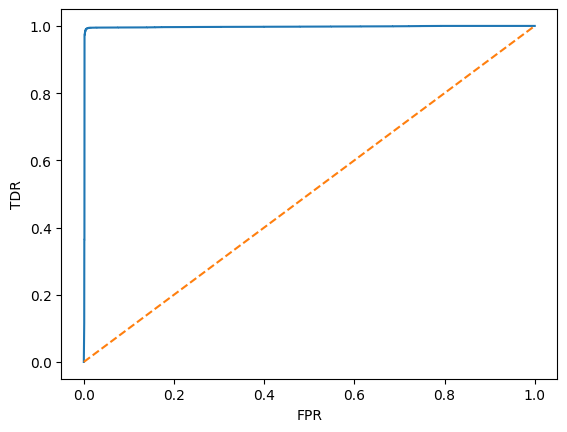

In [56]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TDR')
plt.show()

Model seems to be pretty much operating at a maximum, but lets try some more advanced techniques to try and optimize even further. 

## Oversampling
Coming back to the class imbalance of how often the fire alarm went off, I went with oversampling as I have a dataset under 100,000.

In [57]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {0:n_pos,1:n_neg*3}
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio,random_state=42)
X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

logit_rs = LogisticRegression()
logit_rs.fit(X_train_rs,y_train_rs)
proba_logit_rs = logit_rs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_logit_rs)
print("The score for logistic regression is")
print("Training: {:.2f}%".format(100*logit_rs.score(X_train_rs, y_train_rs)))
print("Training Precision Score: {:.2f}".format(precision_score(y_train_rs,logit_rs.predict(X_train_rs))))
print("Training F1 Score: {:.2f}".format(f1_score(y_train_rs,logit_rs.predict(X_train_rs))))

print("Test set: {:.2f}%".format(100*logit_rs.score(X_test, y_test)))
print("Test Precision Score: {:.2f}".format(precision_score(y_test,logit_rs.predict(X_test))))
print("Test F1 Score: {:.2f}".format(f1_score(y_test,logit_rs.predict(X_test))))

C:\Users\Angus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (40164) in class 1 will be larger than the number of samples in the majority class (class #1 -> 33584)
  warnings.warn(


The score for logistic regression is
Training: 98.54%
Training Precision Score: 1.00
Training F1 Score: 0.99
Test set: 98.31%
Test Precision Score: 1.00
Test F1 Score: 0.99


C:\Users\Angus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Grid Search to tune C
Further tuning of Logistic Regression model to optimize C parameter

In [58]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logit_search = GridSearchCV(LogisticRegression(solver='liblinear'),param_grid,scoring = ['accuracy','f1','precision'],refit='f1')
logit_search.fit(X_train,y_train)
logit_search.best_params_

print('Mean F1: %.2f'%logit_search.best_score_)
print('Config: %s'%logit_search.best_params_)

Mean F1: 0.99
Config: {'C': 1}


## Gradient Boosting
More complex modeling through Gradient Boosting to further otimize performance

In [59]:
import xgboost as xgb
gbm = xgb.XGBRegressor(
                        n_estimators = 3000,
                        max_depth=3,
                        objective='reg:squarederror',
                        learning_rate=.1,
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        eval_metric='rmse',
                        early_stopping_rounds=50
                        )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model=gbm.fit(X_train,y_train,eval_set=eval_set,verbose=False)

In [60]:
y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("MSE: %.2f" %mse)
print("RMSE: %.2f" %(mse**(1/2.0)))

print("Training: {:.2f}%".format(100*fit_model.score(X_train, y_train)))

print("Test set: {:.2f}%".format(100*fit_model.score(X_test, y_test)))

MSE: 0.00
RMSE: 0.00
Training: 100.00%
Test set: 100.00%


## Complexity
All of the models we've looked at so far seem to operate at almost 100% predictive power or at 100% predictive power. 

Model selection might come down to the complexity and how fast or easily these decisions are made.

In [64]:
import time
start_time = time.time()
logit_solver.predict(X_test)
time.time()-start_time

0.0020020008087158203

In [65]:
start_time = time.time()
gbm.predict(X_test)
time.time()-start_time

0.10299944877624512